In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import Model
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle

print(tf.__version__)
print('TensorFlow version:',tf.__version__)
print('Keras version:',tf.keras.__version__)

2.4.1
TensorFlow version: 2.4.1
Keras version: 2.4.0


In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
classes = pd.read_csv("data/Train.csv")

min_width, max_width = max(classes.Width), min(classes.Width)
min_height, max_height = max(classes.Height), min(classes.Height)

print(np.mean([min_width, max_width]))
print(np.mean([min_height, max_height]))

134.0
125.0


In [4]:
classes_no = len(classes.ClassId.unique())
print("There are {} unique classes in the dataset.".format(classes_no))

There are 43 unique classes in the dataset.


Load the data and use data augmentation

In [5]:
cwd = os.getcwd()
base_dir = os.path.join(cwd, 'data')
train_path= os.path.join(base_dir, 'Train')
test_path= os.path.join(base_dir, 'Test')

In [6]:
BATCH_SIZE = 150
STEPS_PER_EPOCH = 2000
TARGET_SIZE = (86, 86)

In [7]:
# Create a data generator for the training images
train_datagen = ImageDataGenerator(
                                rescale=1./255,
                                rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.2,
                                validation_split=0.2)  # val 20%

# Create a data generator for the validation images
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Split data to training and validation datasets
train_data = train_datagen.flow_from_directory(train_path, 
                                               target_size=TARGET_SIZE, 
                                               color_mode='grayscale',
                                               batch_size=BATCH_SIZE, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=2,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory(train_path, 
                                           target_size=TARGET_SIZE, 
                                           color_mode='grayscale',
                                           batch_size=BATCH_SIZE, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=2,
                                           subset = 'validation')

datagen = ImageDataGenerator(rescale=1./255)
test_data = datagen.flow_from_directory(test_path,
                                        target_size=TARGET_SIZE, 
                                        color_mode='grayscale',
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


In [8]:
X_batch, y_batch = next(train_data, 15)

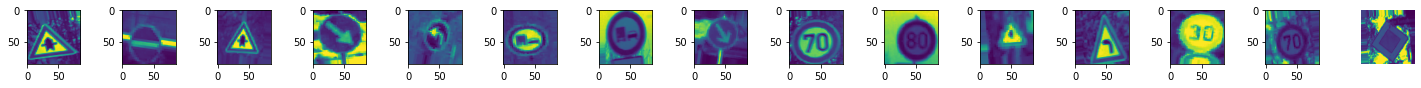

In [9]:
fig, ax = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    ax[i].imshow(X_batch[i].reshape(TARGET_SIZE[0], TARGET_SIZE[1]))
    plt.axis("off")

In [10]:
ACCURACY_THRESHOLD = 0.990

class myCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val accuracy') > ACCURACY_THRESHOLD):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callback = myCallback()

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

LeNEt 5 model    

In [11]:
def leNet():
    
    filters_no=60
    filter_size=(5,5)
    filter_size2=(3,3)
    size_of_pool=(2,2)
    no_of_nodes=500

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(filters=filters_no, kernel_size=filter_size, activation='relu', input_shape=(TARGET_SIZE[0], TARGET_SIZE[0], 1)))
    
    model.add(layers.Conv2D(filters=filters_no, kernel_size=filter_size, activation='relu'))
    
    model.add(layers.MaxPooling2D(pool_size=size_of_pool))

    model.add(layers.Conv2D(filters=filters_no//2, kernel_size=filter_size2, activation='relu'))
    
    model.add(layers.Conv2D(filters=filters_no//2, kernel_size=filter_size2, activation='relu'))

    model.add(layers.MaxPooling2D(pool_size=size_of_pool))

    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())

    model.add(layers.Dense(units=no_of_nodes, activation='relu'))

    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(units=classes_no, activation = 'softmax'))
    
    return model

In [12]:
from tensorflow.keras.optimizers import Adam

lenet = leNet()
lenet.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
lenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 82, 82, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 78, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 35, 35, 30)        8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 30)        0         
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 30)        0

In [13]:
start_time = datetime.datetime.now()
print(start_time)

2021-04-13 20:55:27.674610


In [56]:
history = lenet.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=20,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      #callbacks=[early_stopping],
      verbose=1)

Epoch 1/20
209/209 [==============================] - 81s 389ms/step - loss: 0.0803 - accuracy: 0.9738 - val_loss: 0.1615 - val_accuracy: 0.9512
Epoch 2/20
209/209 [==============================] - 97s 465ms/step - loss: 0.0803 - accuracy: 0.9733 - val_loss: 0.1570 - val_accuracy: 0.9536
Epoch 3/20
209/209 [==============================] - 98s 466ms/step - loss: 0.0825 - accuracy: 0.9738 - val_loss: 0.1865 - val_accuracy: 0.9463
Epoch 4/20
209/209 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9742

KeyboardInterrupt: 

In [15]:
end_time = datetime.datetime.now()
print(end_time)

duration = end_time - start_time
print(duration)

2021-04-13 22:29:27.431668
1:33:59.757058


Save model

In [ ]:
lenet.save('trained_model/lenet_86x86') 

Save model history

In [3]:
cwd = os.getcwd()
model_path = os.path.join(cwd, "trained_model/lenet_86x86")

In [4]:
model_path

'C:\\Users\\LONAA32\\Documents\\Repos\\traffic-sign-recognition\\trained_model/lenet_86x86'

Save model history

In [22]:
#import json

#with open('history.json', 'w') as file:

#    json.dump(history.history, file)

In [6]:
import json

with open('history.json', 'r') as json_file:
    
    history = json.load(json_file)

In [ ]:
class ModelHistory(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

with open(model_path+'/history', 'wb') as file:
    model_history= ModelHistory(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

In [ ]:
#Load model history
with open(model_path+'/history', 'rb') as file:
    history=pickle.load(file)

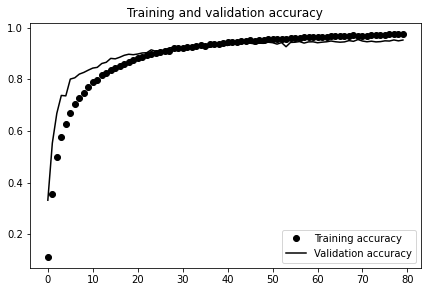

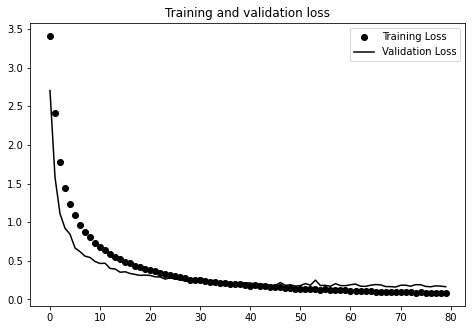

In [31]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(7,4.5))

plt.plot(epochs, acc, 'ko', label='Training accuracy')
plt.plot(epochs, val_acc, 'k', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('outputs/Training Accuracy.png', dpi=200, bbox_inches='tight')

plt.figure(figsize=(7.8,5.2))

plt.plot(epochs, loss, 'ko', label='Training Loss')
plt.plot(epochs, val_loss, 'k', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('outputs/Training Loss.png', dpi=200, bbox_inches='tight')


plt.show()

### Load saved model

In [ ]:
cwd = os.getcwd()
model_path = os.path.join(cwd, "trained_model/lenet_86x86")
lenet = tf.keras.models.load_model(model_path)

In [23]:
results = lenet.evaluate(test_data, batch_size=20)

85/85 [==============================] - 69s 818ms/step - loss: 0.1050 - accuracy: 0.9702


In [24]:
X_test_batch, y_test_batch = next(test_data, 15)

In [25]:
predictions = np.argmax(lenet.predict(X_test_batch, steps=1), axis=1)

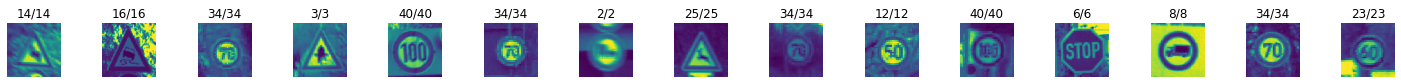

In [27]:
fig, ax = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    ax[i].imshow(X_test_batch[i].reshape(86, 86))
    ax[i].set_title(str(np.argmax(y_test_batch[i])) + "/" + str(predictions[i]))
    ax[i].axis("off")

In [28]:
signs = {}

signs_path = os.path.join(cwd, 'data\Meta')

for i, img_name in enumerate(os.listdir(signs_path)):
    img_path = os.path.join(signs_path, img_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(500, 500))
    signs[i] = img

In [32]:
sample_images = {}
sample_images_array = {}

signs_sample_path = os.path.join(cwd, 'sample_photos')

for i, img_name in enumerate(os.listdir(signs_sample_path)):
    if not img_name.endswith('.ipynb_checkpoints'):
        img_path = os.path.join(signs_sample_path, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(86, 86), color_mode="grayscale")
        
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)  # Add a unit dimension at the front
        
        sample_images_array[img_name.split('.')[0]] = x
        sample_images[img_name.split('.')[0]] = img


In [33]:
sample_images_array['sample_1'].shape

(1, 86, 86, 1)

In [34]:
for name, sample in sample_images_array.items():
    prediction = np.argmax(lenet.predict(sample, steps=1), axis=1)
    print(name, ":", prediction[0])

sample_1 : 6
sample_10 : 35
sample_10a : 24
sample_2 : 12
sample_3 : 1
sample_4 : 36
sample_4a : 6
sample_5 : 3
sample_7 : 21
sample_8 : 12
sample_8a : 1
sample_9 : 6


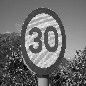

In [54]:
sample_images["sample_3"]

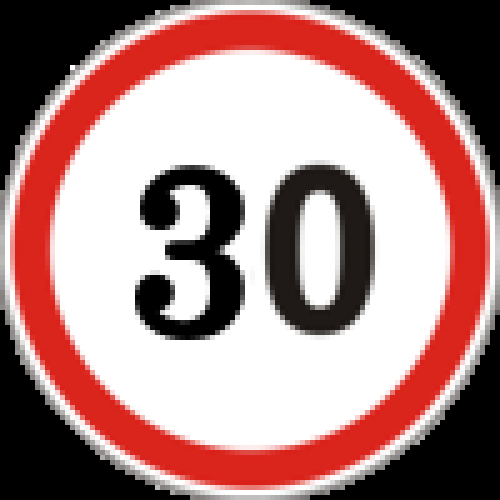

In [55]:
signs[1]